In [3]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt
from sklearn import cross_validation
from sklearn import datasets

# This data has been obtained from the Machine Learning course from Coursera
my_data = genfromtxt('/home/rydrael/projects/ML-FirstSteps/data/ex1data1.txt', delimiter=',')
X = np.matrix(my_data[:, 0]).transpose()

# This data is expressed as a n, 1 array. We need to invert it
y = list(my_data[:, 1])



Let's try several linear regression approaches. FIrst, let's plot 

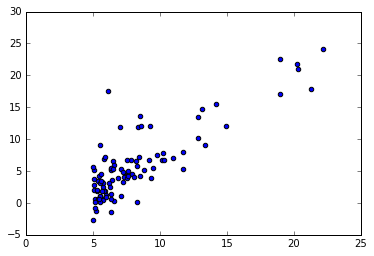

In [4]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.show()

# This function will help to easily compare classifiers
def printScoresAndPlot(X, y, classifier):
    print "Training score: {0}".format(classifier.score(X, y))
    scores = cross_validation.cross_val_score(classifier, X, y, cv=5)
    print "CV score: {0}".format(scores.mean())
    plt.scatter(X, y)
    plt.plot(X, classifier.predict(X), color="r")
    plt.show()

Training score: 0.702031553784
CV score: 0.312889181371


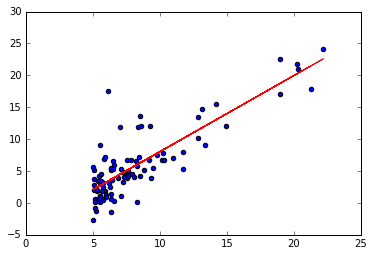

Theta: [-3.89578088  1.19303364]


In [5]:
lr = LinearRegression()
lr.fit(X, y)

printScoresAndPlot(X, y, lr)

print "Theta: {0}".format(np.array([lr.intercept_, lr.coef_]).flatten())

In [6]:
slope, intercept, rvalue, pvalue, stderr = linregress(my_data[:, 0], y)

print rvalue ** 2

0.702031553784


linregress produces the same slope and intercept, however its interface is not as clean as the LinearRegression class. For your information, the p-value determines if the function fulfills the null hypothesis of "slope = 0". A lower value, the better. 

Use the polifit interface

0.702031553784


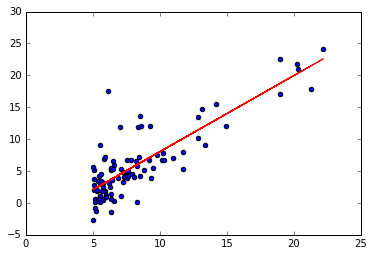

In [12]:
from sklearn.metrics import r2_score

predictor = np.poly1d(np.polyfit(my_data[:, 0], y, deg=1))
r2 = r2_score(y, predictor(X))

print r2

plt.scatter(X, y)
plt.plot(X, predictor(X), color="r")

In [15]:

np.polyfit(my_data[:, 0], y, deg=2)

array([ 0.00379118,  1.10087207, -3.45237794])